XAI apply

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

In [2]:
# Import pandas libraries
import pandas as pd

# Load the dataset
data = pd.read_csv("Data/activemq_result.csv", delimiter=',')
# data = pd.read_csv("Data/avro_result.csv", delimiter=',')


# Explore the dataset
print(data.head()) 


                                         Method name  C20  C3  C4  C1  C5  C6  \
0  org.apache.activemq.transport.amqp.AmqpFramePa...    4  10   1   9   2   5   
1  org.apache.activemq.transport.amqp.AmqpHeader....    5   6   0   6   1   3   
2  org.apache.activemq.transport.amqp.AmqpHeader....    1  13   0  13   3   9   
3  org.apache.activemq.transport.amqp.AmqpInactiv...    1   5   0   5   1   3   
4  org.apache.activemq.transport.amqp.AmqpInactiv...    6   9   0   9   1   5   

   C2  C21  C18  ...  H4  H1  H2  H3       H12       H13       H14   H15  H5  \
0   0    2    4  ...   1   2   2   4  0.200000  0.200000  1.000000   4.0   1   
1   0    5    2  ...   1   1   3   4  0.333333  1.000000  0.333333   4.0   1   
2   0    9    3  ...   1  10   0  10  0.769231  0.000000  0.000000  10.0   1   
3   0    3    1  ...   1   2   0   2  0.400000  0.000000  0.000000   2.0   1   
4   0    4    3  ...   1   3   2   5  0.333333  0.222222  1.500000   5.0   1   

       bug-prone  
0  not bug-pr

In [3]:
# copy data
data_transform = data.copy()

In [4]:

# Convert 'bug-prone' column to 0 and 1
data_transform['bug-prone'] = data_transform['bug-prone'].apply(lambda x: 1 if x.strip() == 'bug-prone' else 0)

# Display the updated DataFrame
print(data_transform.head()) 


                                         Method name  C20  C3  C4  C1  C5  C6  \
0  org.apache.activemq.transport.amqp.AmqpFramePa...    4  10   1   9   2   5   
1  org.apache.activemq.transport.amqp.AmqpHeader....    5   6   0   6   1   3   
2  org.apache.activemq.transport.amqp.AmqpHeader....    1  13   0  13   3   9   
3  org.apache.activemq.transport.amqp.AmqpInactiv...    1   5   0   5   1   3   
4  org.apache.activemq.transport.amqp.AmqpInactiv...    6   9   0   9   1   5   

   C2  C21  C18  ...  H4  H1  H2  H3       H12       H13       H14   H15  H5  \
0   0    2    4  ...   1   2   2   4  0.200000  0.200000  1.000000   4.0   1   
1   0    5    2  ...   1   1   3   4  0.333333  1.000000  0.333333   4.0   1   
2   0    9    3  ...   1  10   0  10  0.769231  0.000000  0.000000  10.0   1   
3   0    3    1  ...   1   2   0   2  0.400000  0.000000  0.000000   2.0   1   
4   0    4    3  ...   1   3   2   5  0.333333  0.222222  1.500000   5.0   1   

   bug-prone  
0          0  
1 

In [5]:

# split feature data and target data
feature_X = data_transform.drop(columns=['Method name','bug-prone'])
y = data_transform['bug-prone']



In [6]:
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import StandardScaler

# Apply SMOTETomek first (on original feature space)
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(feature_X, y)

# Apply StandardScaler after resampling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X = X_scaled
y = y_resampled

In [7]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
# from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models = {
    
    "RandomForest" :  RandomForestClassifier(n_estimators=500, max_depth=None, min_samples_split=5, 
                                       min_samples_leaf=2, class_weight='balanced', random_state=42),
    "AdaBoostClassifier" : AdaBoostClassifier(n_estimators=100, learning_rate=0.8, random_state=42),
    "BaggingClassifier" : BaggingClassifier(n_estimators=100, max_samples=0.8, random_state=42),
    "KNeighborsClassifier" : KNeighborsClassifier(n_neighbors=3, weights='distance', metric='manhattan'),
    "MLPClassifier" : MLPClassifier(activation='relu', hidden_layer_sizes=(200,100), max_iter=2000, 
                               learning_rate='adaptive', random_state=42),
    "HistGradientBoostingClassifier" : HistGradientBoostingClassifier(random_state=42),   
    "DecisionTreeClassifier" : DecisionTreeClassifier(random_state=42),
    "SVC" : SVC(random_state=42, probability=True, C=10, kernel='poly', gamma='scale'),
    "XGBoost": XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=4, random_state=42),
    "CatBoost": CatBoostClassifier(iterations=200, learning_rate=0.05, depth=4, verbose=0, random_state=42)
}




In [8]:
# Import train_test_split library
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing sets (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:

probabilities = []
max_scores = []

# Train all models and get probabilities
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability for class 1
    probabilities.append(y_pred_proba)
    max_scores.append(roc_auc_score(y_test, y_pred_proba))  # Use AUC as weight

# Normalize AUC scores to get weights
weights = [score / sum(max_scores) for score in max_scores]

combined_probs = np.sum([weight * probs for weight, probs in zip(weights, probabilities)], axis=0)

# Determine best threshold using precision-recall
from sklearn.metrics import precision_recall_curve

def get_best_threshold_precision_recall(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.where((precision + recall) == 0, 0, 2 * (precision * recall) / (precision + recall))
    # f1_scores = np.nan_to_num(f1_scores)
    best_threshold = thresholds[np.argmax(f1_scores)]
    return best_threshold

best_threshold_pr = get_best_threshold_precision_recall(y_test, combined_probs)
# adjusted_threshold = best_threshold_pr + 0.05

# Convert probabilities to binary predictions using threshold
predictions = (combined_probs > best_threshold_pr).astype(int)


# Evaluate combined results
print("\nFinal Combined Results:")
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print(f"Precision: {precision_score(y_test, predictions):.4f}")
print(f"Recall: {recall_score(y_test, predictions):.4f}")
print(f"F1-Score: {f1_score(y_test, predictions):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, predictions):.4f}")
print(f"AUC: {roc_auc_score(y_test, combined_probs):.4f}")





Final Combined Results:
Accuracy: 0.8223
Precision: 0.7688
Recall: 0.9133
F1-Score: 0.8348
MCC: 0.6568
AUC: 0.9142


In [10]:
print(X_train.shape, X_test.shape)

print("Total samples:", len(X))

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}, Total: {len(X_train) + len(X_test)}")


(3374, 40) (844, 40)
Total samples: 4218
Train size: 3374, Test size: 844, Total: 4218


In [11]:
feature_names = feature_X.columns

X_train_df = pd.DataFrame(X_train, columns=feature_names)
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Ensure X_test is a DataFrame with column names
# if isinstance(X_test, np.ndarray):
#     X_test = pd.DataFrame(X_test, columns=X_train.columns)


In [12]:
feature_names

Index(['C20', 'C3', 'C4', 'C1', 'C5', 'C6', 'C2', 'C21', 'C18', 'C8', 'C9',
       'C10', 'C17', 'C19', 'C7', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16',
       'H6', 'H7', 'H8', 'H9', 'H10', 'H11', 'H16', 'H17', 'H18', 'H19', 'H4',
       'H1', 'H2', 'H3', 'H12', 'H13', 'H14', 'H15', 'H5'],
      dtype='object')

100%|===================| 1683/1688 [05:54<00:01]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


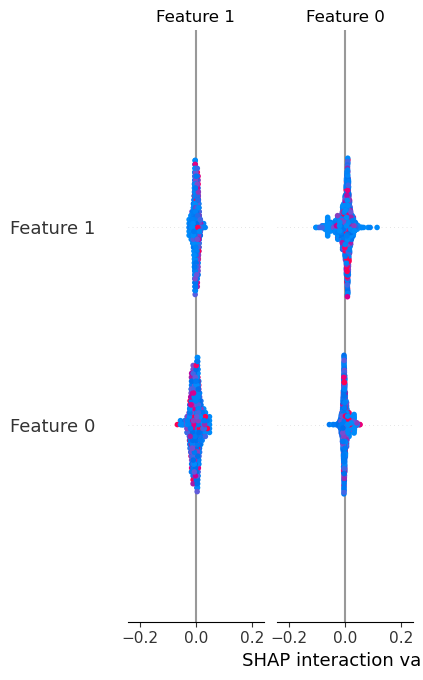

In [13]:
import shap

# Select an interpretable model 
explainer_model = models["RandomForest"]

# Create SHAP Explainer
explainer = shap.Explainer(explainer_model, X_train)

# Compute SHAP values for test data
shap_values = explainer(X_test, check_additivity=False)

# Visualize feature importance
shap.summary_plot(shap_values, X_test)

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

  0%|          | 0/844 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


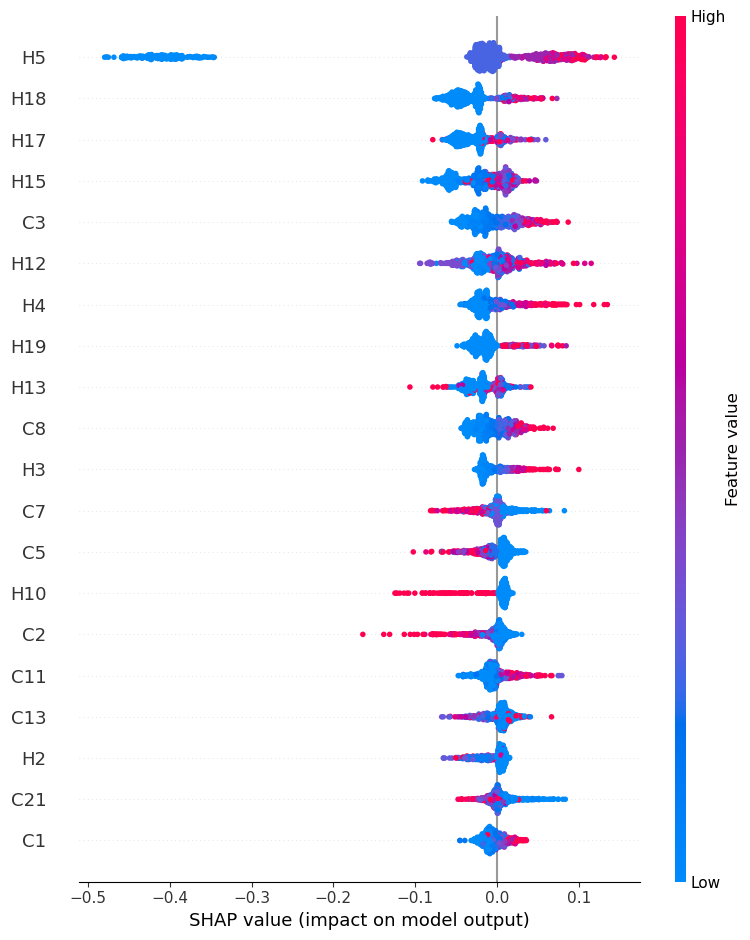

In [14]:
import shap
import numpy as np

X_train_summary = shap.kmeans(X_train, 10)

def get_shap_explainer(name, model, X_train):    
    if isinstance(model, (RandomForestClassifier, DecisionTreeClassifier)):
        se = shap.TreeExplainer(model).shap_values(X_test)    
    else:
        se = shap.KernelExplainer(model.predict_proba, X_train).shap_values(X_test)    
    return se

# Compute SHAP values for all models and average them
shap_values_all = [
    get_shap_explainer(name, models[name], X_train_summary) for name in models.keys()
]

# Ensure all SHAP values have the same shape before computing the mean
shap_values_all = np.array([np.array(sv[1]) if isinstance(sv, list) else np.array(sv) for sv in shap_values_all])
shap_values_combined = np.mean(shap_values_all, axis=0)

# Generate SHAP summary plot
shap.summary_plot(shap_values_combined, X_test_df)


In [190]:
shap_values_combined.shape

(844, 40)

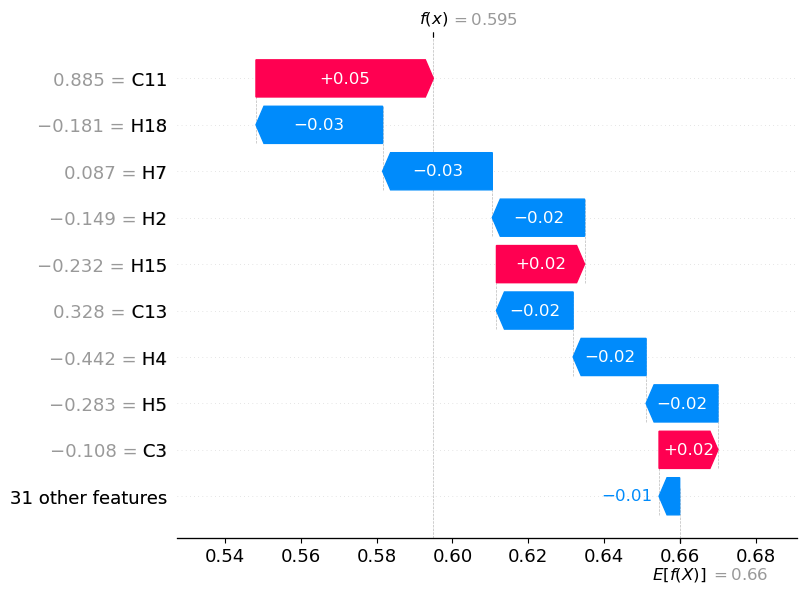

In [22]:
import shap

index = 10  # Change index to visualize a different instance
shap_values_instance = shap_values_combined[index, :]
feature_values = X_test_df.iloc[index, :]
base_value = combined_probs[index]

# Create SHAP Explanation object
explanation = shap.Explanation(values=shap_values_instance, 
                               base_values=base_value,
                               data=feature_values,
                               feature_names=X_test_df.columns)

# Generate the waterfall plot
shap.waterfall_plot(explanation)


In [21]:
if predictions[index] == 1:
    print("buggy")
else:
    print("not buggy")

buggy


In [16]:
shap.initjs()
shap.force_plot(base_value, shap_values_instance, feature_values)


In [ ]:
import lime
import lime.lime_tabular
import numpy as np

# Create a LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_df.values,  # Training data
    feature_names=X_train_df.columns,  # Column names
    class_names=["Not Buggy", "Buggy"],  # Class labels
    mode="classification"
)

# Choose an instance to explain
index = 10  # Change this to explain a different instance
instance = X_test_df.iloc[index].values.reshape(1, -1)

def predict_fn(x):
    # Get probabilities from all models for LIME's perturbed instances
    probabilitieslime = [model.predict_proba(x)[:, 1] for model in models.values()]
    
    # Compute weighted sum using previously computed weights
    combined_probs_lime = np.sum([w * p for w, p in zip(weights, probabilitieslime)], axis=0)

    # Return probabilities for both classes
    return np.column_stack((1 - combined_probs_lime, combined_probs_lime))  # [P(class 0), P(class 1)]

# Explain the instance using LIME
exp = explainer.explain_instance(
    data_row=X_test_df.iloc[index],  
    predict_fn=predict_fn  
)

# Display explanation
exp.show_in_notebook()


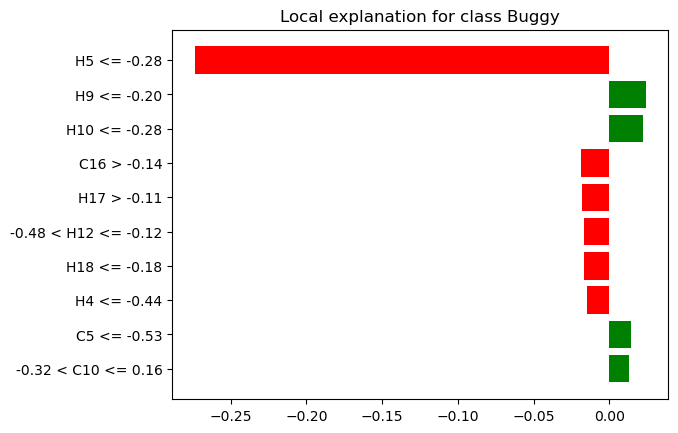

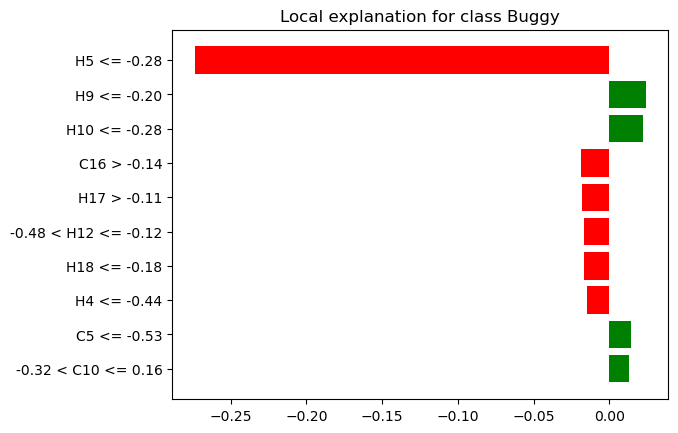

In [ ]:
# Plot explanation
exp.as_pyplot_figure()